In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagra3204/sentiment-and-emotion-analysis-dataset")

print("Path to dataset files:", path)


100%|██████████| 14.9M/14.9M [00:00<00:00, 23.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset/versions/1


In [ ]:
import os

# List files in the first dataset directory
files1 = os.listdir(path)
print("Files in Dataset 1 directory:", files1)



Files in Dataset 1 directory: ['archive']


In [ ]:
import pandas as pd

# Load the first dataset (adjust file name if necessary)
df1 = pd.read_csv(path + "/archive/combined_emotion.csv")  # Adjust path and file name as needed
print("Columns of Dataset 1:", df1.columns)
print("dataset 1 shape:", df1.shape)


Columns of Dataset 1: Index(['sentence', 'emotion'], dtype='object')
dataset 1 shape: (422746, 2)


In [ ]:
# Rename columns in df1 as needed
df1 = df1.rename(columns={"sentence": "text", "emotion": "emotion"})

# Keep only necessary columns in df1
df1 = df1[["text", "emotion"]]

# Check result
print("Dataset shape:", df1.shape)
print(df1.head())

# Save the dataframe to a CSV file
df1.to_csv("emotion_dataset.csv", index=False)

print("Dataset saved as 'emotion_dataset.csv'")


Dataset shape: (422746, 2)
                                                text emotion
0      i just feel really helpless and heavy hearted    fear
1  ive enjoyed being able to slouch about relax a...     sad
2  i gave up my internship with the dmrg and am f...    fear
3                         i dont know i feel so lost     sad
4  i am a kindergarten teacher and i am thoroughl...    fear
Dataset saved as 'emotion_dataset.csv'


In [ ]:
print(df1['text'].isnull().sum())
print(df1.loc[df1['text'].isnull()])

0
Empty DataFrame
Columns: [text, emotion]
Index: []


In [ ]:
import nltk

# Force fresh download of all required resources
nltk.download('punkt', force=True)
nltk.download('punkt_tab')
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)  # Needed for full lemmatization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin

stop_words = set(stopwords.words('english'))

def text_processing(text):
    # Remove any non-alphabet characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Split into words
    words = text.split()
    # Initialize stemmer
    ps = PorterStemmer()
    # Remove stopwords and stem the words
    processed_words = [ps.stem(word) for word in words if word not in stop_words]
    # Join back to string
    return ' '.join(processed_words)


class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=True, stem=True):
        self.lower = lower
        self.stem = stem
        self.ps = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def process(text):
            # Remove non-alphabet chars
            text_clean = re.sub('[^a-zA-Z]', ' ', text)
            # Lowercase if specified
            if self.lower:
                text_clean = text_clean.lower()
            # Split to tokens
            words = text_clean.split()
            # Remove stopwords
            words = [w for w in words if w not in self.stop_words]
            # Stem if specified
            if self.stem:
                words = [self.ps.stem(w) for w in words]
            # Join back to string
            return ' '.join(words)

        return [process(text) for text in X]

In [ ]:
# Initialize the processor (with default lower=True, stem=True)
processor = TextProcessor()

# If you have a list of texts (or a DataFrame column)
texts = df1['text'].tolist()

# Transform texts using the class
processed_texts = processor.transform(texts)

# Assign back to DataFrame
df1['processed_text_class'] = processed_texts

print(df1[['text', 'processed_text_class']])

                                                     text  \
0           i just feel really helpless and heavy hearted   
1       ive enjoyed being able to slouch about relax a...   
2       i gave up my internship with the dmrg and am f...   
3                              i dont know i feel so lost   
4       i am a kindergarten teacher and i am thoroughl...   
...                                                   ...   
422741                 i begun to feel distressed for you   
422742  i left feeling annoyed and angry thinking that...   
422743  i were to ever get married i d have everything...   
422744  i feel reluctant in applying there because i w...   
422745  i just wanted to apologize to you because i fe...   

                                     processed_text_class  
0                        feel realli helpless heavi heart  
1       ive enjoy abl slouch relax unwind frankli need...  
2                    gave internship dmrg feel distraught  
3                          

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Max number of words to keep in the tokenizer
max_len = 100      # Max length of each sequence (in tokens)

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df1['processed_text_class'])

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df1['processed_text_class'])

# Pad sequences so they all have the same length
X = pad_sequences(sequences, maxlen=max_len)

print(X.shape)


(422746, 100)


In [ ]:
df1['emotion'] = df1['emotion'].replace({
    'sadness': 'sad',
    'suprise': 'surprise'
})

# Check unique emotions after replacement
print(df1['emotion'].unique())

['fear' 'sad' 'love' 'joy' 'surprise' 'anger']


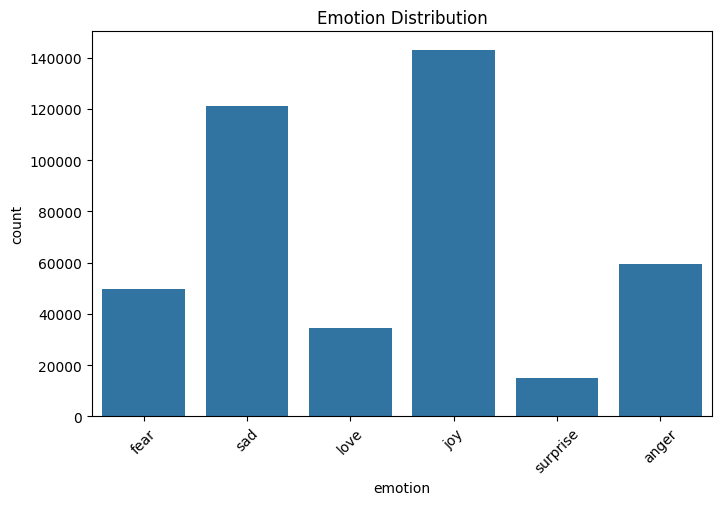

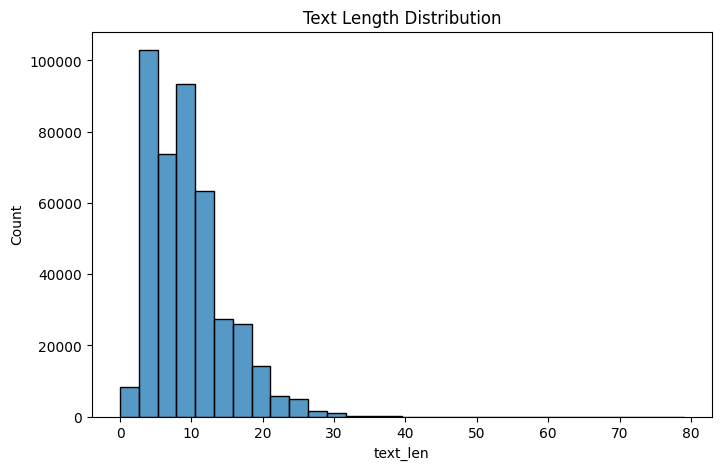

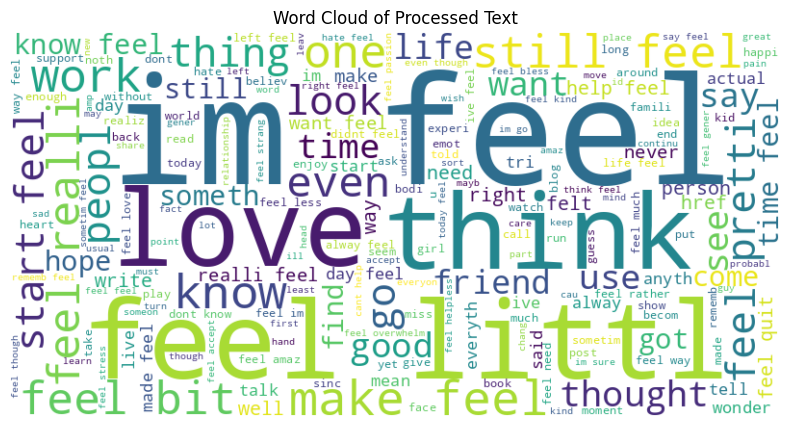

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='emotion', data=df1)
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

# Text length distribution
df1['text_len'] = df1['processed_text_class'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(df1['text_len'], bins=30)
plt.title("Text Length Distribution")
plt.show()

# Word Cloud
text_combined = " ".join(df1['processed_text_class'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Processed Text")
plt.show()


In [ ]:
# -----------------------------------
# Label Encoding (shared for both)
# -----------------------------------
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['label'] = le.fit_transform(df1['emotion'])

# -----------------------------------
# Classical ML: TF-IDF + Train/Test/Val Split
# -----------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df1['processed_text_class'])  # Assume this column exists
y_classical = df1['label']

X_train_val, X_test_classical, y_train_val, y_test_classical = train_test_split(
    X_tfidf, y_classical, test_size=0.2, random_state=42, stratify=y_classical)

X_train_classical, X_val_classical, y_train_classical, y_val_classical = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# -----------------------------------
# Deep Learning: Tokenizer + Padding + One-hot Labels + Train/Test/Val Split
# -----------------------------------
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df1['text'])
sequences = tokenizer.texts_to_sequences(df1['text'])

max_len = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
y_dl = to_categorical(df1['label'], num_classes=len(le.classes_))

# Split: 80% train+val, 20% test
X_train_val_dl, X_test_dl, y_train_val_dl, y_test_dl = train_test_split(
    padded_sequences, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Split: 80% of train_val → train, 20% → val → (64% train, 16% val)
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_val_dl, y_train_val_dl, test_size=0.2, random_state=42, stratify=y_train_val_dl)

# -----------------------------
# Final shapes check (optional)
# -----------------------------
print("TF-IDF - Train:", X_train_classical.shape)
print("TF-IDF - Val:", X_val_classical.shape)
print("TF-IDF - Test:", X_test_classical.shape)

print("DL - Train:", X_train_dl.shape)
print("DL - Val:", X_val_dl.shape)
print("DL - Test:", X_test_dl.shape)


TF-IDF - Train: (270556, 5000)
TF-IDF - Val: (67640, 5000)
TF-IDF - Test: (84550, 5000)
DL - Train: (270556, 178)
DL - Val: (67640, 178)
DL - Test: (84550, 178)


## ML Models


Training Naive Bayes...

Model: Naive Bayes (Best Params: {'alpha': 1.0}):
  Train Accuracy = 0.8200
  Val Accuracy   = 0.8084
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.92      0.73      0.81      9491
        fear       0.89      0.67      0.76      7944
         joy       0.74      0.96      0.84     22891
        love       0.93      0.36      0.52      5529
         sad       0.82      0.93      0.87     19390
    surprise       0.95      0.23      0.37      2395

    accuracy                           0.81     67640
   macro avg       0.87      0.65      0.69     67640
weighted avg       0.83      0.81      0.79     67640



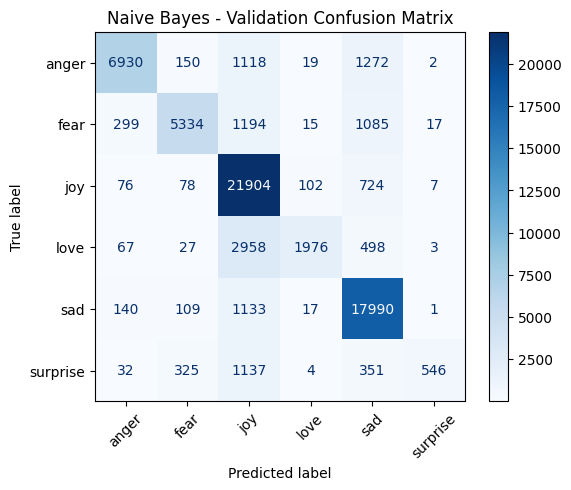


Training Logistic Regression...

Model: Logistic Regression (Best Params: {'C': 1}):
  Train Accuracy = 0.8931
  Val Accuracy   = 0.8752
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.88      0.88      0.88      9491
        fear       0.84      0.83      0.84      7944
         joy       0.89      0.91      0.90     22891
        love       0.78      0.68      0.73      5529
         sad       0.91      0.92      0.92     19390
    surprise       0.73      0.68      0.70      2395

    accuracy                           0.88     67640
   macro avg       0.84      0.82      0.83     67640
weighted avg       0.87      0.88      0.87     67640



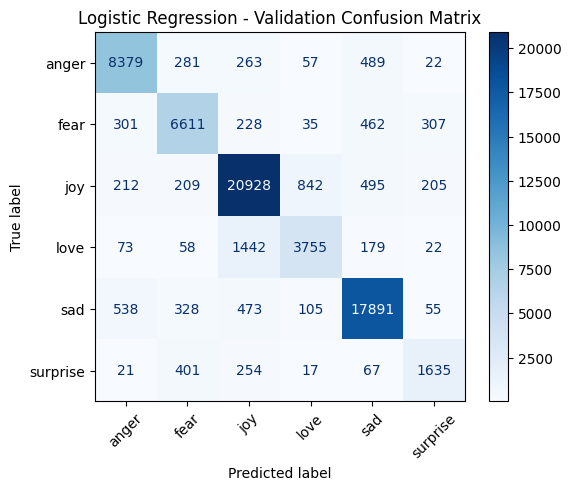


Training Gradient Boosting...

Model: Gradient Boosting (Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_iter_no_change': 5, 'validation_fraction': 0.1}):
  Train Accuracy = 0.8136
  Val Accuracy   = 0.8100
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.92      0.73      0.81      9491
        fear       0.91      0.70      0.79      7944
         joy       0.72      0.93      0.81     22891
        love       0.81      0.56      0.66      5529
         sad       0.92      0.81      0.86     19390
    surprise       0.63      0.93      0.76      2395

    accuracy                           0.81     67640
   macro avg       0.82      0.78      0.78     67640
weighted avg       0.83      0.81      0.81     67640



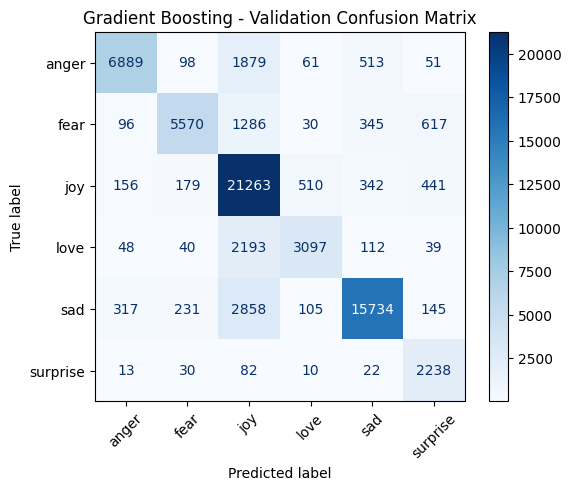


Training Linear SVM...

Model: Linear SVM (Best Params: {'C': 1}):
  Train Accuracy = 0.8996
  Val Accuracy   = 0.8784
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.88      0.89      0.89      9491
        fear       0.83      0.84      0.84      7944
         joy       0.89      0.91      0.90     22891
        love       0.79      0.69      0.74      5529
         sad       0.92      0.93      0.92     19390
    surprise       0.71      0.70      0.71      2395

    accuracy                           0.88     67640
   macro avg       0.84      0.83      0.83     67640
weighted avg       0.88      0.88      0.88     67640



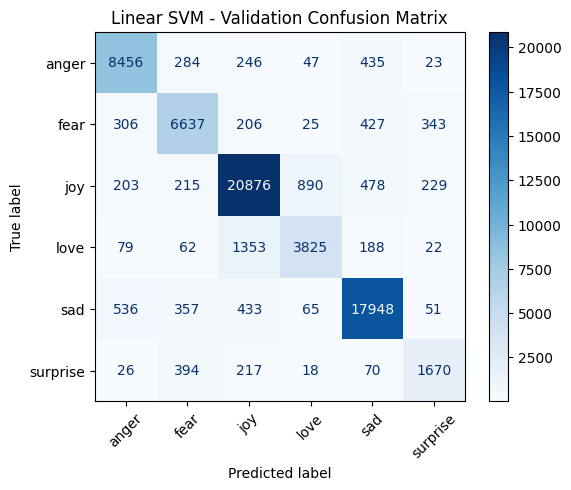


Training K-Nearest Neighbors...

Model: K-Nearest Neighbors (Best Params: {'n_neighbors': 3}):
  Train Accuracy = 0.6880
  Val Accuracy   = 0.5141
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.28      0.77      0.41      9491
        fear       0.37      0.51      0.43      7944
         joy       0.75      0.48      0.59     22891
        love       0.67      0.28      0.40      5529
         sad       0.82      0.52      0.64     19390
    surprise       0.70      0.28      0.40      2395

    accuracy                           0.51     67640
   macro avg       0.60      0.47      0.48     67640
weighted avg       0.65      0.51      0.54     67640



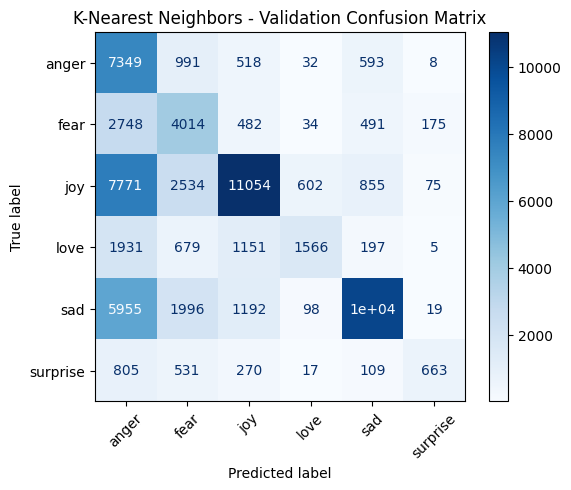


Training Decision Tree...

Model: Decision Tree (Best Params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}):
  Train Accuracy = 0.8987
  Val Accuracy   = 0.8092
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.79      0.86      0.82      9491
        fear       0.75      0.79      0.77      7944
         joy       0.85      0.83      0.84     22891
        love       0.64      0.60      0.62      5529
         sad       0.87      0.85      0.86     19390
    surprise       0.61      0.62      0.61      2395

    accuracy                           0.81     67640
   macro avg       0.75      0.76      0.75     67640
weighted avg       0.81      0.81      0.81     67640



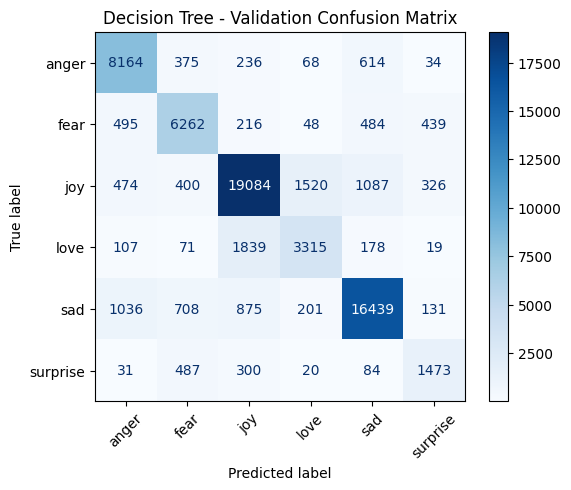


Training MLP Classifier...

Model: MLP Classifier (Best Params: {'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (128,), 'validation_fraction': 0.1}):
  Train Accuracy = 0.8942
  Val Accuracy   = 0.8762
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.88      0.89      0.88      9491
        fear       0.83      0.85      0.84      7944
         joy       0.89      0.91      0.90     22891
        love       0.76      0.71      0.73      5529
         sad       0.92      0.91      0.92     19390
    surprise       0.73      0.70      0.72      2395

    accuracy                           0.88     67640
   macro avg       0.84      0.83      0.83     67640
weighted avg       0.88      0.88      0.88     67640



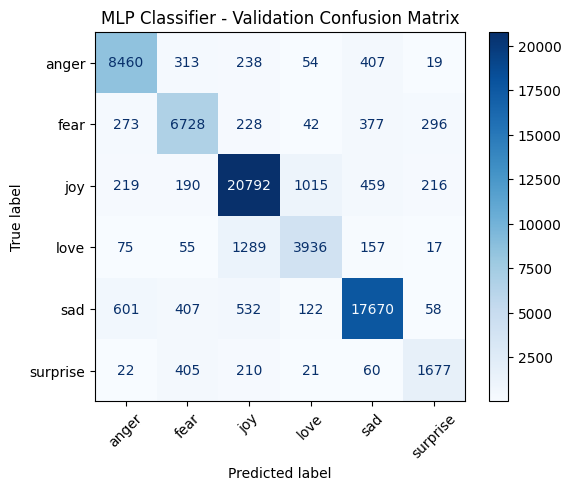

<ipython-input-13-af14cf680442>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_vals), y=list(model_names), palette="mako")


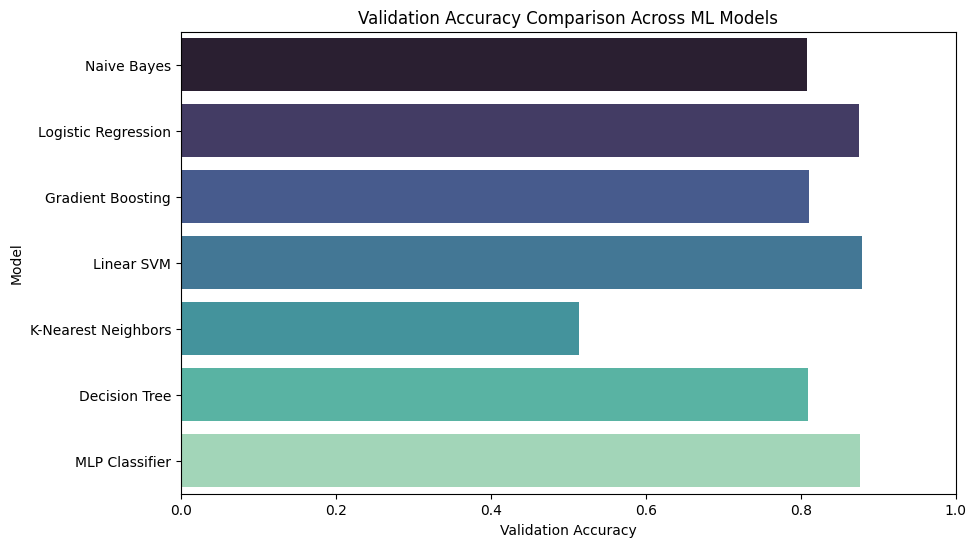


Evaluating the Best Model (Linear SVM) on the Test Set:
  Test Accuracy = 0.8793
  Classification Report (Test):
               precision    recall  f1-score   support

       anger       0.88      0.89      0.88     11863
        fear       0.83      0.84      0.84      9930
         joy       0.90      0.91      0.91     28614
        love       0.79      0.70      0.74      6911
         sad       0.92      0.92      0.92     24238
    surprise       0.73      0.69      0.71      2994

    accuracy                           0.88     84550
   macro avg       0.84      0.83      0.83     84550
weighted avg       0.88      0.88      0.88     84550



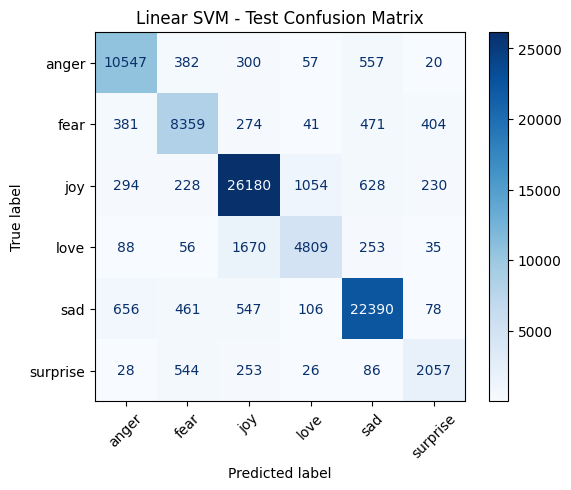

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter grids
param_grids = {
    "Naive Bayes": {
        "alpha": [0.1, 1.0, 10.0]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        "max_depth": [10, 15, 20, None],
        "min_samples_leaf": [1, 2, 4],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [100],
        "learning_rate": [0.1],
        "max_depth": [3],
        "n_iter_no_change": [5],
        "validation_fraction": [0.1]
    },
    "Linear SVM": {
        "C": [0.01, 0.1, 1]
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7]
    },
    "MLP Classifier": {
        "hidden_layer_sizes": [(64,), (128,)],
        "alpha": [0.0001, 0.001],
        "early_stopping": [True],
        "validation_fraction": [0.1]
    }
}

# Base models
base_models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Linear SVM": LinearSVC(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(max_iter=300, random_state=42)
}

# Store best model details
best_model = None
best_val_accuracy = 0
best_model_name = ""

# Store for visualization
val_accuracies = []

# Train + evaluate
for name in base_models:
    print(f"\nTraining {name}...")
    grid = GridSearchCV(base_models[name], param_grids[name], cv=3, n_jobs=-1)
    grid.fit(X_train_classical, y_train_classical)

    current_model = grid.best_estimator_

    y_train_pred = current_model.predict(X_train_classical)
    y_val_pred = current_model.predict(X_val_classical)
    y_test_pred = current_model.predict(X_test_classical)

    val_accuracy = accuracy_score(y_val_classical, y_val_pred)
    val_accuracies.append((name, val_accuracy))

    print(f"\nModel: {name} (Best Params: {grid.best_params_}):")
    print(f"  Train Accuracy = {accuracy_score(y_train_classical, y_train_pred):.4f}")
    print(f"  Val Accuracy   = {val_accuracy:.4f}")
    print("  Classification Report (Validation):\n", classification_report(y_val_classical, y_val_pred, target_names=le.classes_))

    # Visual Confusion Matrix for Validation Set
    ConfusionMatrixDisplay.from_predictions(
        y_val_classical, y_val_pred, display_labels=le.classes_,
        cmap='Blues', xticks_rotation=45
    )
    plt.title(f"{name} - Validation Confusion Matrix")
    plt.grid(False)
    plt.show()

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = current_model
        best_model_name = name

# Compare Model Accuracies
model_names, accuracy_vals = zip(*val_accuracies)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_vals), y=list(model_names), palette="mako")
plt.xlabel("Validation Accuracy")
plt.ylabel("Model")
plt.title("Validation Accuracy Comparison Across ML Models")
plt.xlim(0, 1)
plt.show()

# Final Evaluation on Test Set
if best_model:
    print(f"\nEvaluating the Best Model ({best_model_name}) on the Test Set:")
    y_test_pred_best = best_model.predict(X_test_classical)
    test_accuracy_best = accuracy_score(y_test_classical, y_test_pred_best)
    print(f"  Test Accuracy = {test_accuracy_best:.4f}")
    print("  Classification Report (Test):\n", classification_report(y_test_classical, y_test_pred_best, target_names=le.classes_))

    #Final Confusion Matrix for Test Set
    ConfusionMatrixDisplay.from_predictions(
        y_test_classical, y_test_pred_best, display_labels=le.classes_,
        cmap='Blues', xticks_rotation=45
    )
    plt.title(f"{best_model_name} - Test Confusion Matrix")
    plt.grid(False)
    plt.show()


In [ ]:
custom_text = "I'm really confused and feel lost right now."

# Preprocess using your TextProcessor class (stem, stopword removal, lowercase)
processed_custom_text = processor.transform([custom_text])

# Convert processed text to TF-IDF vector (using your fitted TF-IDF vectorizer)
custom_tfidf = tfidf.transform(processed_custom_text)

# Predict emotion
predicted_label_idx = best_model.predict(custom_tfidf)

# Decode label back to original emotion label
predicted_emotion = le.inverse_transform(predicted_label_idx)

print("Predicted Emotion:", predicted_emotion[0])


Predicted Emotion: fear


# Deep Learning Models for Emotion Detection

In [ ]:
# Data preparation (continued from previous steps)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, concatenate, Multiply, Activation, Lambda

# Tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df1['text'])
sequences = tokenizer.texts_to_sequences(df1['text'])

max_len = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
# Define num_classes here
num_classes = len(le.classes_)
y_dl = to_categorical(df1['label'], num_classes=num_classes)


# Split: 80% train+val, 20% test
X_train_val_dl, X_test_dl, y_train_val_dl, y_test_dl = train_test_split(
    padded_sequences, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Split: 80% of train_val → train, 20% → val → (64% train, 16% val)
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_val_dl, y_train_val_dl, test_size=0.2, random_state=42, stratify=y_train_val_dl)


print("DL - Train:", X_train_dl.shape)
print("DL - Val:", X_val_dl.shape)
print("DL - Test:", X_test_dl.shape)


DL - Train: (270556, 178)
DL - Val: (67640, 178)
DL - Test: (84550, 178)


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Multiply, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# ========== Model Builder Functions ==========
def build_model(name, vocab_size, max_len, num_classes):
    input_layer = Input(shape=(max_len,))
    x = Embedding(vocab_size, 128, input_length=max_len)(input_layer)

    if name == "LSTM":
        x = LSTM(64)(x)
    elif name == "BiLSTM":
        x = Bidirectional(LSTM(64))(x)
    elif name == "GRU":
        x = GRU(128)(x)
    elif name == "BiGRU":
        x = Bidirectional(GRU(64))(x)
    elif name == "1D_CNN":
        x = Conv1D(128, kernel_size=5, activation='relu')(x)
        x = GlobalMaxPooling1D()(x)
    elif name == "CNN_BiLSTM":
        x = Conv1D(64, kernel_size=5, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Bidirectional(LSTM(64))(x)
    elif name == "CNN_Attention":
        filter_sizes = [3, 4, 5]
        conv_outputs = []
        for filter_size in filter_sizes:
            conv = Conv1D(128, filter_size, activation='relu')(x)
            pool = GlobalMaxPooling1D()(conv)
            conv_outputs.append(pool)
        merged = concatenate(conv_outputs)
        attention_probs = Dense(merged.shape[-1], activation='softmax')(merged)
        x = Multiply()([merged, attention_probs])
    else:
        raise ValueError("Unknown model name")

    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# ========== Training & Plotting Function ==========
def train_and_plot(model, X_train, y_train, X_val, y_val, name, epochs=5, batch_size=64):
    print(f"\nTraining {name}...")
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Training Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training LSTM...
Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.3297 - loss: 1.5889 - val_accuracy: 0.3384 - val_loss: 1.5757
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.3383 - loss: 1.5760 - val_accuracy: 0.3384 - val_loss: 1.5760
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.3385 - loss: 1.5762 - val_accuracy: 0.3384 - val_loss: 1.5750
Epoch 4/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 66s 16ms/step - accuracy: 0.3387 - loss: 1.5744 - val_accuracy: 0.3384 - val_loss: 1.5750
Epoch 5/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.3380 - loss: 1.5751 - val_accuracy: 0.3384 - val_loss: 1.5751


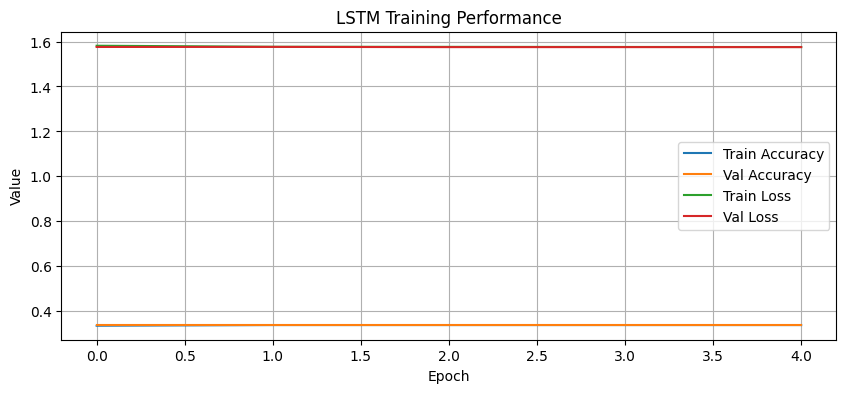

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

LSTM Accuracy: 0.3384
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      9491
        fear       0.00      0.00      0.00      7944
         joy       0.34      1.00      0.51     22891
        love       0.00      0.00      0.00      5529
         sad       0.00      0.00      0.00     19390
    surprise       0.00      0.00      0.00      2395

    accuracy                           0.34     67640
   macro avg       0.06      0.17      0.08     67640
weighted avg       0.11      0.34      0.17     67640

Confusion Matrix:
[[    0     0  9491     0     0     0]
 [    0     0  7944     0     0     0]
 [    0     0 22891     0     0     0]
 [    0     0  5529     0     0     0]
 [    0     0 19390     0     0     0]
 [    0     0  2395     0     0     0]]

Training BiLSTM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.7962 - loss: 0.5337 - val_accuracy: 0.9319 - val_loss: 0.1215
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - accuracy: 0.9368 - loss: 0.1214 - val_accuracy: 0.9344 - val_loss: 0.1055
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 95s 22ms/step - accuracy: 0.9416 - loss: 0.1018 - val_accuracy: 0.9342 - val_loss: 0.1014
Epoch 4/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 145s 23ms/step - accuracy: 0.9441 - loss: 0.0921 - val_accuracy: 0.9324 - val_loss: 0.1095
Epoch 5/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 139s 23ms/step - accuracy: 0.9464 - loss: 0.0874 - val_accuracy: 0.9278 - val_loss: 0.1137


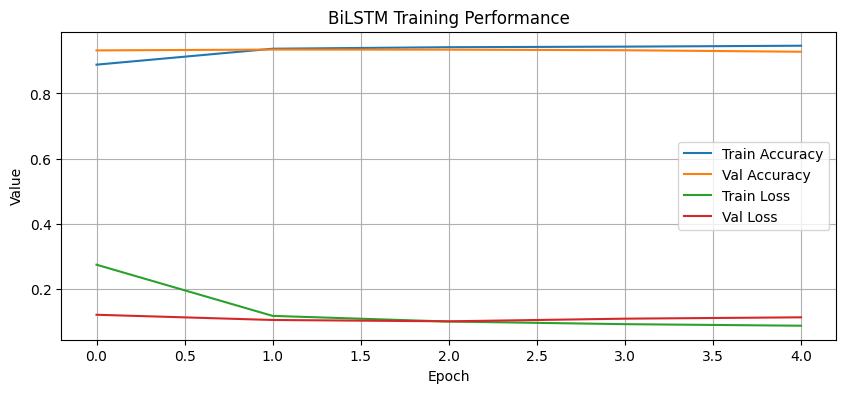

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

BiLSTM Accuracy: 0.9342
Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.95      0.94      9491
        fear       0.86      0.94      0.90      7944
         joy       0.93      0.98      0.95     22891
        love       0.94      0.73      0.82      5529
         sad       0.98      0.96      0.97     19390
    surprise       0.90      0.67      0.77      2395

    accuracy                           0.93     67640
   macro avg       0.92      0.87      0.89     67640
weighted avg       0.94      0.93      0.93     67640

Confusion Matrix:
[[ 8978   280    41     3   188     1]
 [  238  7503    20     0   140    43]
 [   66    10 22442   244    15   114]
 [    2     0  1508  4014     4     1]
 [  394   286    26     6 18659    19]
 [    4   643   151     1     0  1596]]

Training GRU...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 73s 17ms/step - accuracy: 0.3320 - loss: 1.5851 - val_accuracy: 0.3384 - val_loss: 1.5783
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 86s 18ms/step - accuracy: 0.3382 - loss: 1.5779 - val_accuracy: 0.3384 - val_loss: 1.5752
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - accuracy: 0.3399 - loss: 1.5766 - val_accuracy: 0.3384 - val_loss: 1.5757
Epoch 4/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 76s 18ms/step - accuracy: 0.3394 - loss: 1.5741 - val_accuracy: 0.3384 - val_loss: 1.5761


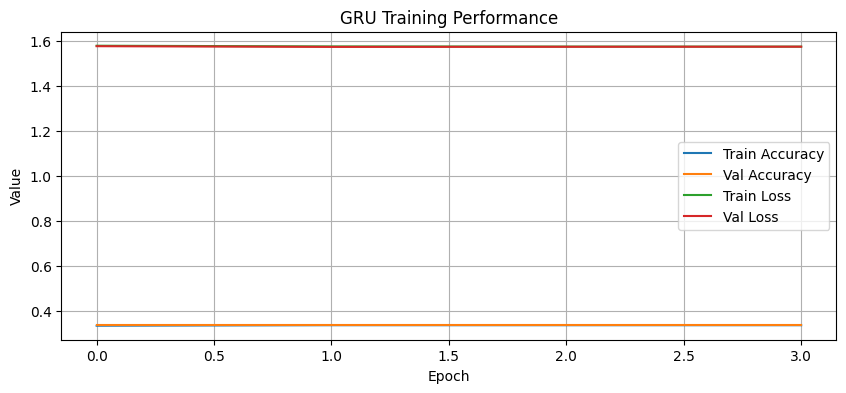

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

GRU Accuracy: 0.3384
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      9491
        fear       0.00      0.00      0.00      7944
         joy       0.34      1.00      0.51     22891
        love       0.00      0.00      0.00      5529
         sad       0.00      0.00      0.00     19390
    surprise       0.00      0.00      0.00      2395

    accuracy                           0.34     67640
   macro avg       0.06      0.17      0.08     67640
weighted avg       0.11      0.34      0.17     67640

Confusion Matrix:
[[    0     0  9491     0     0     0]
 [    0     0  7944     0     0     0]
 [    0     0 22891     0     0     0]
 [    0     0  5529     0     0     0]
 [    0     0 19390     0     0     0]
 [    0     0  2395     0     0     0]]

Training BiGRU...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 98s 23ms/step - accuracy: 0.7779 - loss: 0.5641 - val_accuracy: 0.9366 - val_loss: 0.1065
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - accuracy: 0.9411 - loss: 0.1099 - val_accuracy: 0.9356 - val_loss: 0.1024
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - accuracy: 0.9440 - loss: 0.0977 - val_accuracy: 0.9325 - val_loss: 0.1026
Epoch 4/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 145s 23ms/step - accuracy: 0.9460 - loss: 0.0897 - val_accuracy: 0.9308 - val_loss: 0.1087


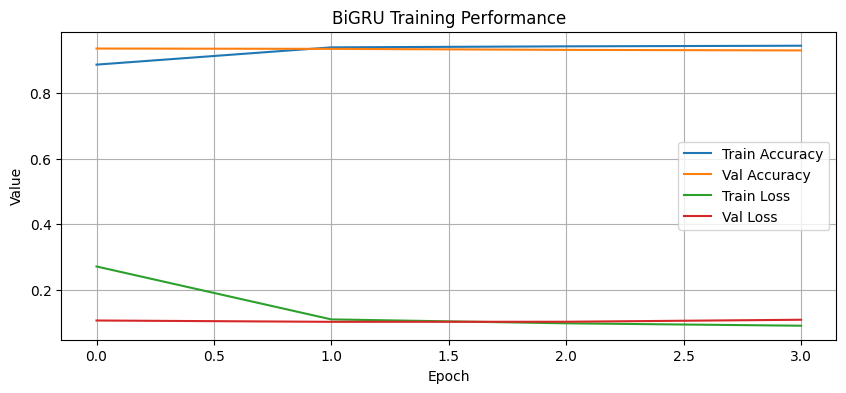

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

BiGRU Accuracy: 0.9356
Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.92      0.94      9491
        fear       0.86      0.95      0.90      7944
         joy       0.96      0.95      0.95     22891
        love       0.81      0.88      0.85      5529
         sad       0.97      0.97      0.97     19390
    surprise       0.95      0.64      0.77      2395

    accuracy                           0.94     67640
   macro avg       0.92      0.89      0.90     67640
weighted avg       0.94      0.94      0.94     67640

Confusion Matrix:
[[ 8725   287    43     1   435     0]
 [  209  7564    24     0    82    65]
 [   48    10 21664  1137    17    15]
 [    0     0   643  4886     0     0]
 [  103   344    29     6 18902     6]
 [    1   636   202     1    12  1543]]

Training 1D_CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.8214 - loss: 0.4582 - val_accuracy: 0.9255 - val_loss: 0.1439
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9297 - loss: 0.1557 - val_accuracy: 0.9219 - val_loss: 0.1443
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9343 - loss: 0.1392 - val_accuracy: 0.9215 - val_loss: 0.1541


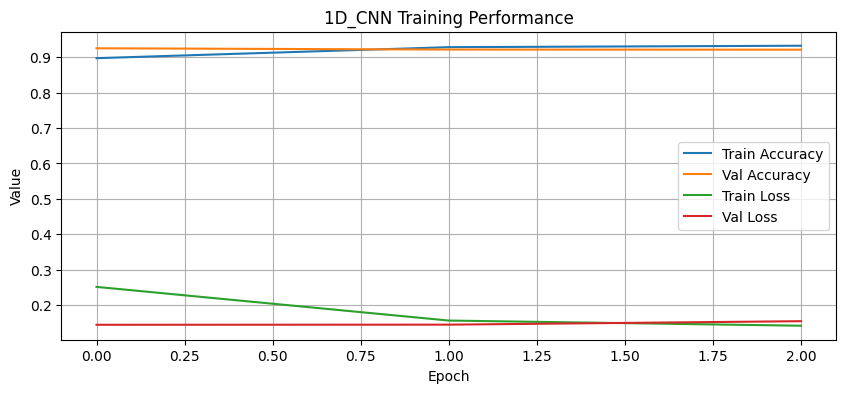

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

1D_CNN Accuracy: 0.9255
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.95      0.93      9491
        fear       0.95      0.83      0.88      7944
         joy       0.95      0.93      0.94     22891
        love       0.80      0.87      0.83      5529
         sad       0.96      0.97      0.96     19390
    surprise       0.74      0.89      0.81      2395

    accuracy                           0.93     67640
   macro avg       0.89      0.91      0.89     67640
weighted avg       0.93      0.93      0.93     67640

Confusion Matrix:
[[ 8990   105    98    13   280     5]
 [  343  6591    83     7   362   558]
 [   92    25 21316  1149   140   169]
 [   10     6   675  4798    36     4]
 [  377   105   100    16 18782    10]
 [    1   141    99     3    29  2122]]

Training CNN_BiLSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.8189 - loss: 0.4663 - val_accuracy: 0.9326 - val_loss: 0.1259
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - accuracy: 0.9368 - loss: 0.1211 - val_accuracy: 0.9343 - val_loss: 0.1068
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.9416 - loss: 0.1016 - val_accuracy: 0.9342 - val_loss: 0.1072
Epoch 4/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 142s 19ms/step - accuracy: 0.9437 - loss: 0.0937 - val_accuracy: 0.9329 - val_loss: 0.1139


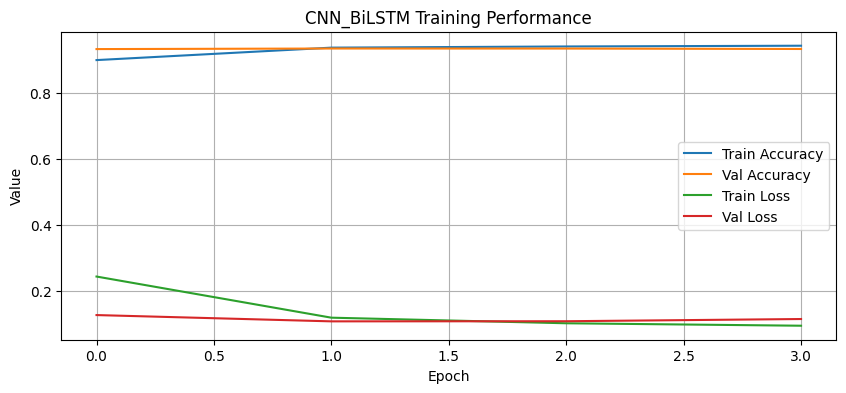

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

CNN_BiLSTM Accuracy: 0.9343
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.96      0.94      9491
        fear       0.89      0.90      0.90      7944
         joy       0.93      0.98      0.95     22891
        love       0.95      0.73      0.82      5529
         sad       0.98      0.97      0.97     19390
    surprise       0.81      0.76      0.78      2395

    accuracy                           0.93     67640
   macro avg       0.91      0.88      0.89     67640
weighted avg       0.93      0.93      0.93     67640

Confusion Matrix:
[[ 9099    72    60     2   257     1]
 [  392  7147    29     4    98   274]
 [   86     7 22404   219    30   145]
 [    2     0  1497  4019    10     1]
 [  322   312    28     6 18714     8]
 [    4   449   112     1    16  1813]]

Training CNN_Attention...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.6393 - loss: 0.9012 - val_accuracy: 0.9233 - val_loss: 0.1720
Epoch 2/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 74s 10ms/step - accuracy: 0.8473 - loss: 0.3562 - val_accuracy: 0.9260 - val_loss: 0.1530
Epoch 3/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.8775 - loss: 0.2803 - val_accuracy: 0.9276 - val_loss: 0.1399
Epoch 4/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - accuracy: 0.8940 - loss: 0.2365 - val_accuracy: 0.9253 - val_loss: 0.1375
Epoch 5/5
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - accuracy: 0.9012 - loss: 0.2130 - val_accuracy: 0.9239 - val_loss: 0.1357


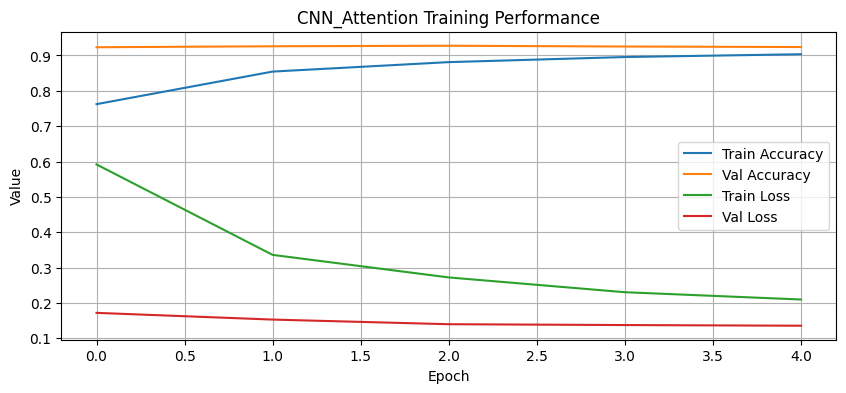

2114/2114 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

CNN_Attention Accuracy: 0.9239
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.95      0.93      9491
        fear       0.86      0.92      0.89      7944
         joy       0.96      0.92      0.94     22891
        love       0.78      0.87      0.82      5529
         sad       0.97      0.96      0.97     19390
    surprise       0.83      0.72      0.77      2395

    accuracy                           0.92     67640
   macro avg       0.89      0.89      0.89     67640
weighted avg       0.93      0.92      0.92     67640

Confusion Matrix:
[[ 8991   308    54     4   133     1]
 [  220  7272    38     0   301   113]
 [  108    30 21114  1359    74   206]
 [    4     1   689  4817    12     6]
 [  474   203   105    17 18573    18]
 [    0   593    64     5     7  1726]]

Best Model: BiGRU with Accuracy = 0.9356


In [ ]:
# ========== Model Names ==========
model_names = ["LSTM", "BiLSTM", "GRU", "BiGRU", "1D_CNN", "CNN_BiLSTM", "CNN_Attention"]

# ========== Training All Models ==========
models = {}
accuracies = {}

for name in model_names:
    model = build_model(name, vocab_size, max_len, num_classes)
    model = train_and_plot(model, X_train_dl, y_train_dl, X_val_dl, y_val_dl, name)

    loss, acc = model.evaluate(X_val_dl, y_val_dl, verbose=0)
    accuracies[name] = acc
    models[name] = model

    y_pred = np.argmax(model.predict(X_val_dl), axis=1)
    y_true = np.argmax(y_val_dl, axis=1)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# ========== Best Model ==========
best_model_name = max(accuracies, key=accuracies.get)
print(f"\nBest Model: {best_model_name} with Accuracy = {accuracies[best_model_name]:.4f}")

In [ ]:
# ========== Predict on Custom Sentence ==========
best_model = models[best_model_name]

custom_text = "I can't stop smiling today, everything feels perfect!"
processed_custom_text = processor.transform([custom_text])
custom_seq = tokenizer.texts_to_sequences(processed_custom_text)
custom_pad = pad_sequences(custom_seq, maxlen=max_len, padding='post')

prediction = best_model.predict(custom_pad)
predicted_idx = np.argmax(prediction, axis=1)
predicted_emotion = le.inverse_transform(predicted_idx)

print(f"\n Predicted Emotion: {predicted_emotion[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

 Predicted Emotion: joy
